In [34]:
import pandas as pd

train_raw = pd.read_csv("train_raw.csv")
test_raw = pd.read_csv("test_raw.csv")

In [38]:
y_train = train_raw["Survived"]
X_train_raw = train_raw.drop(columns=["Survived"])

In [39]:
X_train_raw = X_train_raw.drop(columns=["title"], errors="ignore")

categorical_cols = [
    "Sex",
    "Embarked",
    "Pclass",
    "title_group",
    "cabin_deck",
    "is_alone"
]

numeric_cols = [c for c in X_train_raw.columns if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numerical columns: ",numeric_cols)

Categorical columns: ['Sex', 'Embarked', 'Pclass', 'title_group', 'cabin_deck', 'is_alone']
Numerical columns:  ['Age', 'SibSp', 'Parch', 'Fare', 'name_length', 'family_size', 'ticket_group_size', 'fare_per_person', 'age_fare_ratio', 'cabin_room_number', 'cabin_score', 'name_word_count']


In [40]:
na_counts = X_train_raw.isna().sum().sort_values(ascending=False)
na_counts[na_counts > 0]

cabin_room_number    525
Age                  131
Embarked               2
dtype: int64

In [41]:
missing = [c for c in categorical_cols if c not in X_train_raw.columns]
missing

[]

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

In [43]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    logreg_pipe,         
    X_train_raw,
    y_train,
    cv=cv,
    scoring="accuracy"   
)

print("CV scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Std CV score:", cv_scores.std())


CV scores: [0.8358209  0.82835821 0.85074627 0.85714286 0.78195489]
Mean CV score: 0.830804623499046
Std CV score: 0.026490815113643262


In [44]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__class_weight": [None, "balanced"],
    "model__solver": ["liblinear"]  
}

grid = GridSearchCV(
    estimator=logreg_pipe,    
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train_raw, y_train)

print("Best CV accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)


Best CV accuracy: 0.8368084390079676
Best params: {'model__C': 10, 'model__class_weight': None, 'model__solver': 'liblinear'}


In [45]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)

plot_df = results[[
    "mean_test_score", "std_test_score",
    "param_model__C", "param_model__class_weight"
]].copy()

plot_df["param_model__C"] = plot_df["param_model__C"].astype(float)
plot_df = plot_df.sort_values(["param_model__class_weight", "param_model__C"])
plot_df.head()


,mean_test_score,std_test_score,param_model__C,param_model__class_weight
1,0.802345,0.030944,0.01,balanced
3,0.809819,0.024460,0.10,balanced
5,0.815857,0.032466,1.00,balanced
7,0.809875,0.034457,10.00,balanced
9,0.803905,0.036496,100.00,balanced


In [46]:
plot_df.to_csv(
    "tables/logistic_cv_results.csv",
    index=False
)

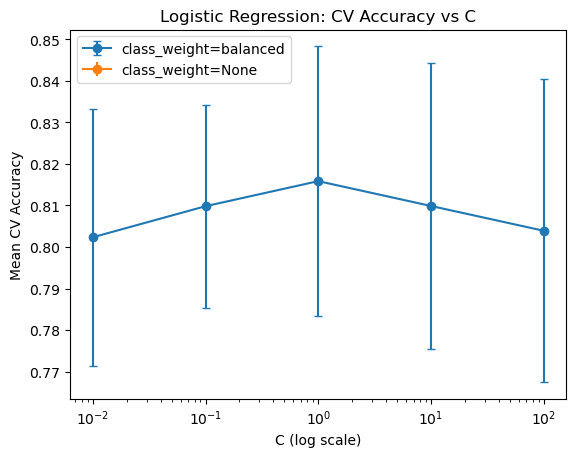

In [47]:
import matplotlib.pyplot as plt

for cw in plot_df["param_model__class_weight"].unique():
    sub = plot_df[plot_df["param_model__class_weight"] == cw]
    plt.errorbar(
        sub["param_model__C"],
        sub["mean_test_score"],
        yerr=sub["std_test_score"],
        marker="o",
        capsize=3,
        label=f"class_weight={cw}"
    )

plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Mean CV Accuracy")
plt.title("Logistic Regression: CV Accuracy vs C")
plt.legend()
plt.savefig(
    "plots/logistic_cv_accuracy_vs_C.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [48]:
best_logreg = grid.best_estimator_


In [49]:
y_test = test_raw["Survived"]
X_test_raw = test_raw.drop(columns=["Survived"]).drop(columns=["title"], errors="ignore")


In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

y_pred = best_logreg.predict(X_test_raw)
acc = accuracy_score(y_test, y_pred)

print("Test Accuracy:", acc)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_prob = best_logreg.predict_proba(X_test_raw)[:, 1]
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))


Test Accuracy: 0.8251121076233184
Confusion Matrix:
 [[117  20]
 [ 19  67]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       137
           1       0.77      0.78      0.77        86

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223

Test ROC AUC: 0.854778475640808


In [51]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

test_metrics = pd.DataFrame({
    "metric": ["accuracy", "roc_auc"],
    "value": [
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ]
})

test_metrics.to_csv(
    "tables/logistic_test_metrics.csv",
    index=False
)


In [52]:
import numpy as np

feature_names = best_logreg.named_steps["preprocess"].get_feature_names_out()
coefs = best_logreg.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

coef_df.head(15)


,feature,coef,abs_coef
20,cat__title_group_Master,1.883065,1.883065
28,cat__cabin_deck_D,1.353572,1.353572
12,cat__Sex_female,1.341543,1.341543
29,cat__cabin_deck_E,1.124061,1.124061
32,cat__cabin_deck_T,-1.074249,1.074249
22,cat__title_group_Mr,-0.985775,0.985775
13,cat__Sex_male,-0.895797,0.895797
33,cat__cabin_deck_Unknown,-0.749966,0.749966
17,cat__Pclass_1,0.713701,0.713701
31,cat__cabin_deck_G,-0.651707,0.651707


In [53]:
coef_df.to_csv(
    "tables/logistic_feature_importance.csv",
    index=False
)

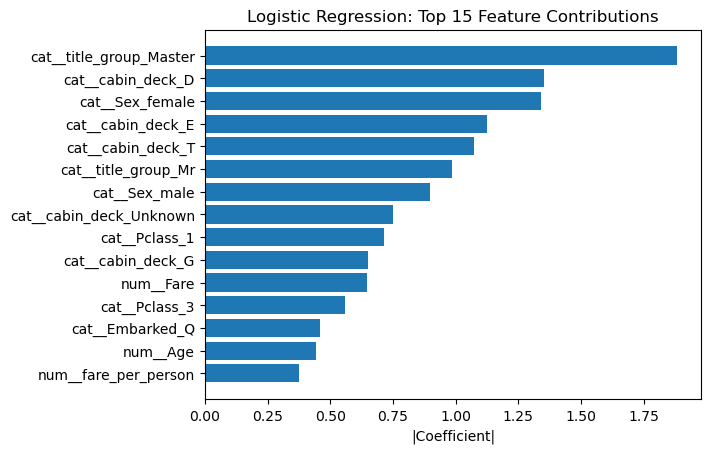

In [55]:
topn = 15
top = coef_df.head(topn).sort_values("abs_coef")

plt.figure()
plt.barh(top["feature"], top["abs_coef"])
plt.xlabel("|Coefficient|")
plt.title(f"Logistic Regression: Top {topn} Feature Contributions")
plt.savefig(
    "plots/logistic_feature_contributions.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
